# Popularity hide and seek
> "A hidden Markov model to estimate latent presidential popularity across time"

- toc: true
- badges: true
- comments: true
- author: Alexandre Andorra, Rémi Louf
- categories: [popularity, Macron, Hidden Markov models, polls]
- image: images/gp-popularity.png

A few months ago, [I experimented with a Gaussian Process](https://alexandorra.github.io/pollsposition_blog/popularity/macron/gaussian%20processes/polls/2021/01/18/gp-popularity.html) to estimate the popularity of French presidents across time. The experiment was really positive, and helped me get familiar with the beauty of GPs. This time, I teamed up with [Rémi Louf](https://twitter.com/remilouf) on a [hidden Markov model](https://en.wikipedia.org/wiki/Hidden_Markov_model) to estimate the same process -- what is the true latent popularity, that we only observe through the noisy data that are polls?

This was supposed to be a trial run before working on an electoral model for the coming regional elections in France -- it's always easier to start with 2 dimensions than 6, right? But the model turned out to be so good at smoothing and predicting popularity data that we thought it'd be a shame not to share it. And voilà!

## Show me the data!

The data are the same as in [my GP post](https://alexandorra.github.io/pollsposition_blog/popularity/macron/gaussian%20processes/polls/2021/01/18/gp-popularity.html), so we're not going to spend a lot of time explaining them. It's basically all the popularity opinion polls of French presidents since the term limits switched to 5 years (in 2002).

Let's import those data, as well as the (fabulous) packages we'll need:

In [1]:
import datetime

import arviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as aet
from scipy.special import expit as logistic

In [2]:
# hide
RANDOM_SEED = 926
np.random.seed(RANDOM_SEED)
arviz.style.use("arviz-darkgrid")

In [3]:
data = pd.read_csv(
    "https://raw.githubusercontent.com/AlexAndorra/pollsposition_models/master/data/raw_popularity_presidents.csv",
    header=0,
    index_col=0,
    parse_dates=True,
)

In [4]:
# hide
# restrict data to after the switch to 5-year term
data = data.loc[data.index >= pd.to_datetime("2002-05-05")]
data["year"] = data.index.year
data["month"] = data.index.month

data["sondage"] = data["sondage"].replace("Yougov", "YouGov")
data["method"] = data["method"].replace("face-to-face&internet", "face to face")

# convert to proportions
data[["approve_pr", "disapprove_pr"]] = (
    data[["approve_pr", "disapprove_pr"]].copy() / 100
)
data = data.rename(columns={"approve_pr": "p_approve", "disapprove_pr": "p_disapprove"})

POLLSTERS = data["sondage"].sort_values().unique()
comment = f"""The dataset contains {len(data)} polls between the years {data["year"].min()} and {data["year"].max()}.
There are {len(POLLSTERS)} pollsters: {', '.join(list(POLLSTERS))}
"""
print(comment)

The dataset contains 1083 polls between the years 2002 and 2021.
There are 10 pollsters: BVA, Elabe, Harris, Ifop, Ipsos, Kantar, Odoxa, OpinionWay, Viavoice, YouGov



The number of polls is homogeneous among months, except in the summer because, well, France:

In [5]:
data["month"].value_counts().sort_index()

1     100
2      96
3     100
4      89
5      91
6      95
7      68
8      71
9      94
10     99
11     98
12     82
Name: month, dtype: int64

Let us look at simple stats on the pollsters:

In [6]:
pd.crosstab(data.sondage, data.method, margins=True)

method      face to face  internet  phone  phone&internet   All
sondage                                                        
BVA                    0       101     89               0   190
Elabe                  0        52      0               0    52
Harris                 0        33      0               0    33
Ifop                   0        29    181              38   248
Ipsos                  0        40    177               0   217
Kantar               208         4      0               0   212
Odoxa                  0        67      0               0    67
OpinionWay             0        12      0               0    12
Viavoice               0        20      0               0    20
YouGov                 0        32      0               0    32
All                  208       390    447              38  1083

Interesting: most pollsters only use one method -- internet. Only BVA, Ifop, Ipsos (and Kantar very recently) use different methods. So, if we naively estimate the biases of pollsters and methods individually, we'll get high correlations in our posterior estimates -- the parameter for `face to face` will basically be the one for `Kantar`, and vice versa. So we will need to model the pairs `(pollster, method)` rather than pollsters and methods individually.

Now, let's just plot the raw data and see what they look like:

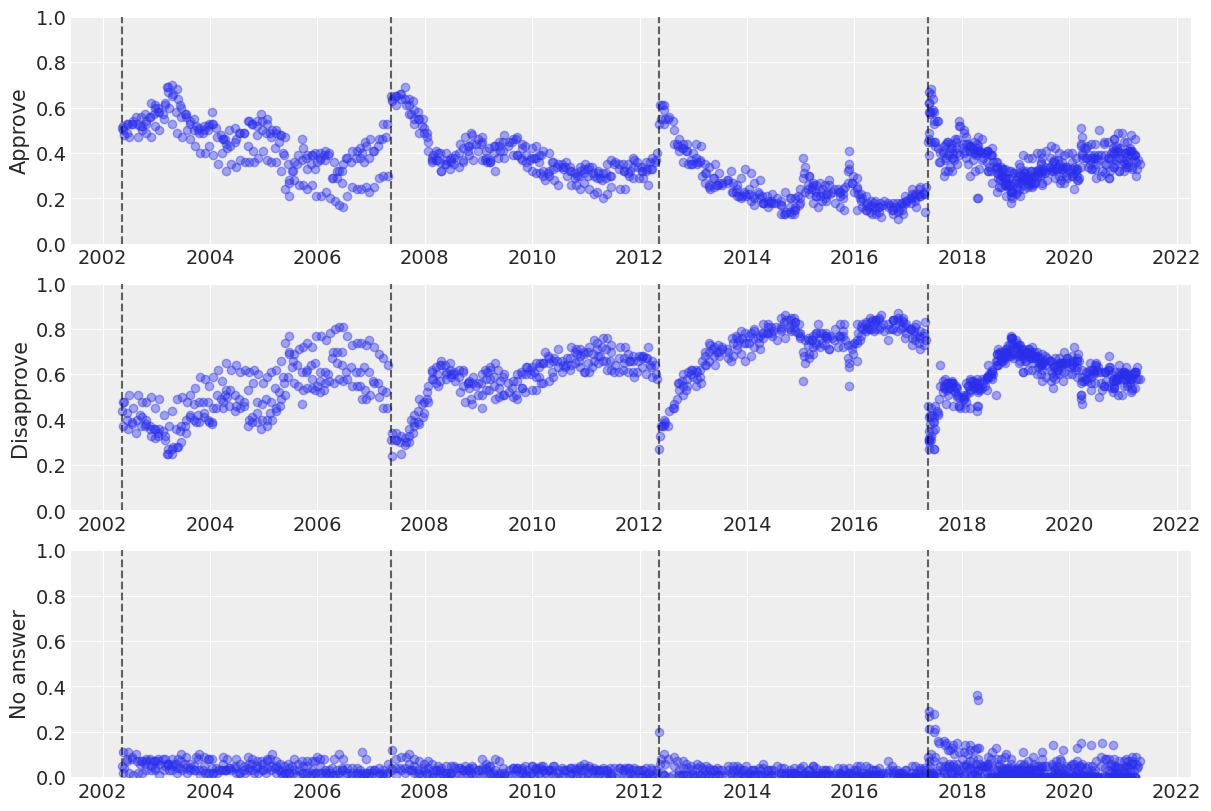

In [7]:
approval_rates = data["p_approve"].values
disapproval_rates = data["p_disapprove"].values
doesnotrespond = 1 - approval_rates - disapproval_rates
newterm_dates = data.reset_index().groupby("president").first()["index"].values
dates = data.index

fig, axes = plt.subplots(3, figsize=(12, 8))
for ax, rate, label in zip(
    axes.ravel(),
    [approval_rates, disapproval_rates, doesnotrespond],
    ["Approve", "Disapprove", "No answer"],
):
    ax.plot(dates, rate, "o", alpha=0.4)
    ax.set_ylim(0, 1)
    ax.set_ylabel(label)
    for date in newterm_dates:
        ax.axvline(date, color="k", alpha=0.6, linestyle="--")

We notice two things when looking at these plots:

1. Approval rates systematically decrease as the goes on.
2. While that's true, some events seem to push the approval rate back up, even though temporarily. This happened in every term, actually. Can that variance really be explained solely with a random walk?
3. Non-response rate is higher during Macron's term.

## Monthly standard deviation

Something that often proves challenging with count data is that they are often more dispersed than traditional models expect them to be. Let's check this now, by computing the monthly standard deviation of the approval rates (we weigh each poll equally, even though we probably should weigh them according to their respective sample size):

In [8]:
rolling_std = (
    data.reset_index()
    .groupby(["year", "month"])
    .std()
    .reset_index()[["year", "month", "p_approve"]]
)
rolling_std

year  month  p_approve
0    2002      5   0.017078
1    2002      6   0.030000
2    2002      7   0.005774
3    2002      8   0.045826
4    2002      9   0.025166
..    ...    ...        ...
223  2020     12   0.064627
224  2021      1   0.042661
225  2021      2   0.041748
226  2021      3   0.042980
227  2021      4   0.020000

[228 rows x 3 columns]

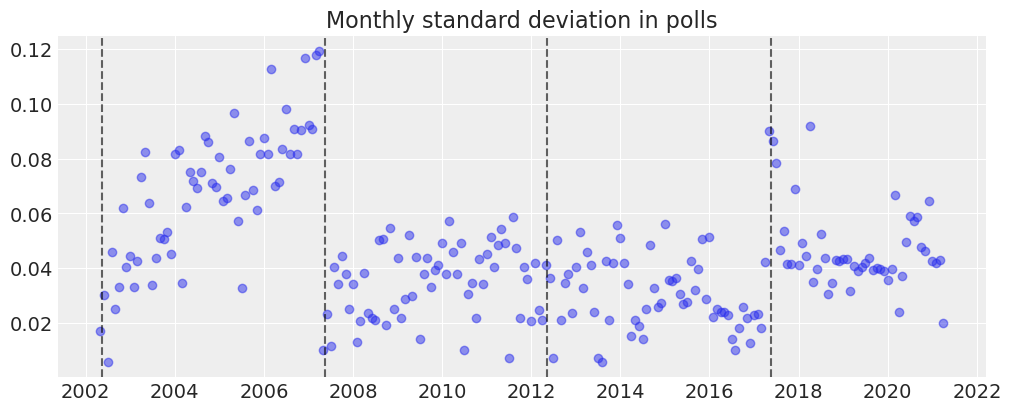

In [9]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(
    pd.to_datetime(
        [f"{y}-{m}-01" for y, m in zip(rolling_std.year, rolling_std.month)]
    ),
    rolling_std.p_approve.values,
    "o",
    alpha=0.5,
)
ax.set_title("Monthly standard deviation in polls")
for date in newterm_dates:
    ax.axvline(date, color="k", alpha=0.6, linestyle="--")

There is a very high variance for Chirac's second term, and for the beggining of Macron's term. For Chirac's term, it seems like the difference stems from the polling method: face-to-face approval rates seem to be much lower. For Macron, this high variance is quite hard to explain. In any case, we'll probably have to take this overdispersion (as it's called in statistical linguo) of the data in our models...

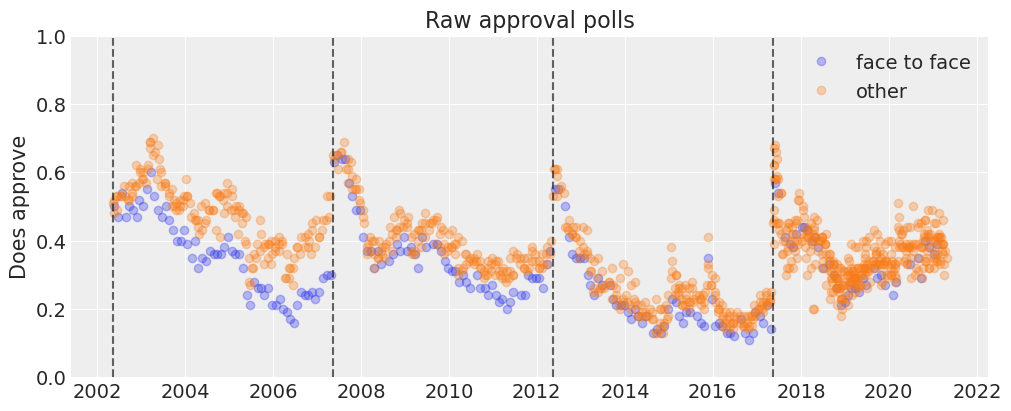

In [10]:
face = data[data["method"] == "face to face"]
dates_face = face.index

other = data[data["method"] != "face to face"]
dates_other = other.index

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(dates_face, face["p_approve"].values, "o", alpha=0.3, label="face to face")
ax.plot(dates_other, other["p_approve"].values, "o", alpha=0.3, label="other")
ax.set_ylim(0, 1)
ax.set_ylabel("Does approve")
ax.set_title("Raw approval polls")
ax.legend()
for date in newterm_dates:
    ax.axvline(date, color="k", alpha=0.6, linestyle="--")

## A raw analysis of bias

As each pollster uses different methods to establish and question their samples each month, we don't expect their results to be identical -- _that_ would be troubling. Instead we expect each pollster and each polling method to be at a different place on the spectrum: some report popularity rates in line with the market average, some are below average, some are above.

The model will be able to estimate this bias on the fly and more seriously (if we tell it to), but let's take a look at a crude estimation ourselves, to get a first idea. Note that we're talking about _statistical_ bias here, not _political_ bias: it's very probable that reaching out to people only by internet or phone can have a [selection effect](https://en.wikipedia.org/wiki/Selection_bias) on your sample, without it being politically motivated -- statistics are just hard and stubborn you know 🤷‍♂️

To investigate bias, we now compute the monthly mean of the $p_{approve}$ values and check how each individual poll strayed from this mean:

In [11]:
data = (
    data.reset_index()
    .merge(
        data.groupby(["year", "month"])["p_approve"].mean().reset_index(),
        on=["year", "month"],
        suffixes=["", "_mean"],
    )
    .rename(columns={"index": "field_date"})
)
data["diff_approval"] = data["p_approve"] - data["p_approve_mean"]
data.round(2)

field_date president sondage  samplesize        method  p_approve  \
0    2002-05-15   chirac2    Ifop         924         phone       0.51   
1    2002-05-20   chirac2  Kantar         972  face to face       0.50   
2    2002-05-23   chirac2     BVA        1054         phone       0.52   
3    2002-05-26   chirac2   Ipsos         907         phone       0.48   
4    2002-06-16   chirac2    Ifop         974         phone       0.49   
...         ...       ...     ...         ...           ...        ...   
1078 2021-03-29    macron  Kantar        1000      internet       0.36   
1079 2021-03-30    macron  YouGov        1068      internet       0.30   
1080 2021-04-07    macron   Elabe        1003      internet       0.33   
1081 2021-04-10    macron   Ipsos        1002      internet       0.37   
1082 2021-04-26    macron  Kantar        1000      internet       0.35   

      p_disapprove  year  month  p_approve_mean  diff_approval  
0             0.44  2002      5            0.50           0.01  
1             0.48  2002      5            0.50          -0.00  
2             0.37  2002      5            0.50           0.02  
3             0.48  2002      5            0.50          -0.02  
4             0.43  2002      6            0.50          -0.02  
...            ...   ...    ...             ...            ...  
1078          0.58  2021      3            0.38          -0.02  
1079          0.61  2021      3            0.38          -0.08  
1080          0.63  2021      4            0.35          -0.02  
1081          0.58  2021      4            0.35           0.02  
1082          0.58  2021      4            0.35           0.00  

[1083 rows x 11 columns]

Then, we can aggregate these offsets by pollster and look at their distributions:

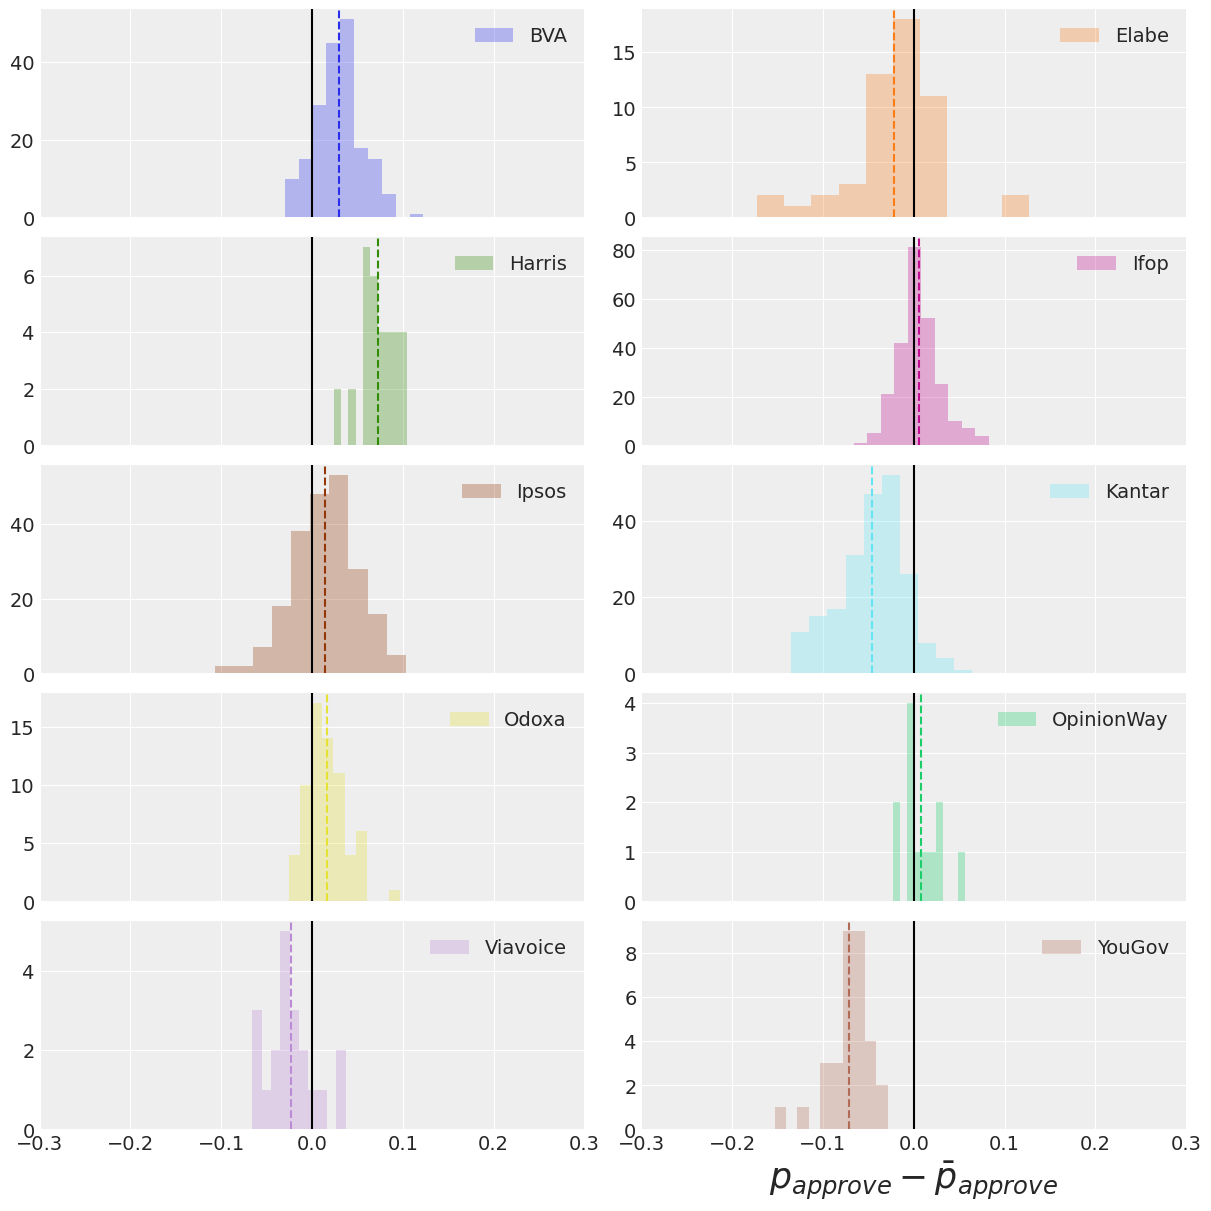

In [12]:
POLLSTER_VALS = {
    pollster: data[data["sondage"] == pollster]["diff_approval"].values
    for pollster in list(POLLSTERS)
}

colors = plt.rcParams["axes.prop_cycle"]()
fig, axes = plt.subplots(ncols=2, nrows=5, sharex=True, figsize=(12, 12))

for ax, (pollster, vals) in zip(axes.ravel(), POLLSTER_VALS.items()):
    c = next(colors)["color"]
    ax.hist(vals, alpha=0.3, color=c, label=pollster)
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")
    ax.axvline(x=0, color="black")
    ax.set_xlim(-0.3, 0.3)
    ax.legend()

plt.xlabel(r"$p_{approve} - \bar{p}_{approve}$", fontsize=25);

A positive (resp. negative) bias means the pollster tends to report higher (resp. lower) popularity rates than the average pollster. We'll see what the model has to say about this, but our prior is that, for instance, YouGov and Kantar tend to be below average, while Harris and BVA tend to be higher.

And now for the bias per method:

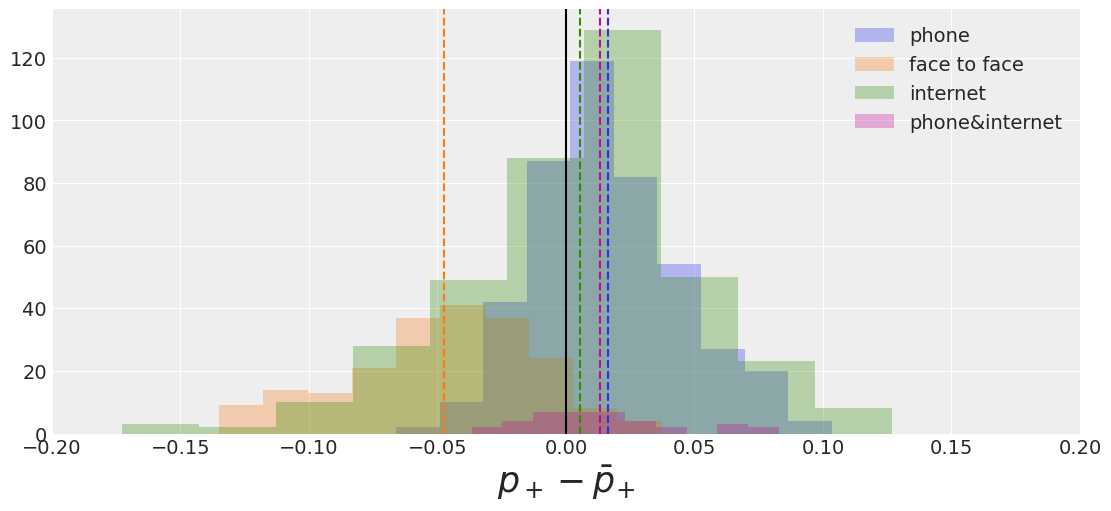

In [13]:
METHOD_VALS = {
    method: data[data["method"] == method]["diff_approval"].values
    for method in list(data["method"].unique())
}

colors = plt.rcParams["axes.prop_cycle"]()
fig, ax = plt.subplots(figsize=(11, 5))

for method, vals in METHOD_VALS.items():
    c = next(colors)["color"]
    ax.hist(vals, alpha=0.3, color=c, label=method)
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")

ax.axvline(x=0, color="black")
ax.set_xlim(-0.2, 0.2)
ax.set_xlabel(r"$p_+ - \bar{p}_{+}$", fontsize=25)
ax.legend();

Face-to-face polls seem to give systematically below-average approval rates, while telephone polls seem to give slightly higher-than-average results.

Again, keep in mind that there is substantial correlation between pollsters and method, so take this with a grain of salt -- that's why it's useful to add that to the model actually: it will be able to decipher these correlations, integrate them into the full data generating process, and report finer estimates of each bias. 

Speaking of models, do you know what time it is? It's model time, of course!!

## Model

We'll build several versions of our model, refining it incrementally. But the basic structure will remain the same. Let's build an abstract version that will help you undertand the code.

Each poll $i$ at month $m$ from the beginning of a president’s term finds that
$y_i$ individuals have a positive opinion of the president’s action over
$n_i$ respondents. We model this as:

$$y_{i,m} \sim Binomial(p_{i,m}, n_{i,m})$$

We loosely call $p_{i,m}$ the *popularity* of the president, $m$ month into his
presidency. This is the quantity we would like to model. Note that it's latent: we never get to observe it in the world.

Why specify the month when the time information is already contained in the
succession of polls? Because French people tend to be less and less satisfied
with their president as their term moves, regardless of their action -- you'll see...

We model $p_{i,m}$ with a random walk logistic regression:

$$p_{i,m} = logistic(\mu_m + \alpha_k + \zeta_j)$$

$\mu_m$ is the underlying support for the president at month $m$. $\alpha_k$ is
the bias of the pollster, while $\zeta_j$ is the inherent bias of the polling
method. The biases are assumed to be completely unpooled at first, i.e we model
one bias for each pollster and method:

$$\alpha_k \sim Normal(0, \sigma_k)\qquad \forall pollster k$$

and 

$$\zeta_j \sim Normal(0, \sigma_j)\qquad \forall method j$$

We treat the time variation of $\mu$ with a correlated random walk:

$$\mu_m | \mu_{m-1} \sim Normal(\mu_{m-1}, \sigma_m)$$

For the sake of simplicity, we choose not to account at first for a natural
decline in popularity $\delta$, the unmeployment at month $m$, $U_m$, or
random events that can happen during the term. 

In [14]:
# hide
data["num_approve"] = np.floor(data["samplesize"] * data["p_approve"]).astype("int")
data

field_date president sondage  samplesize        method  p_approve  \
0    2002-05-15   chirac2    Ifop         924         phone       0.51   
1    2002-05-20   chirac2  Kantar         972  face to face       0.50   
2    2002-05-23   chirac2     BVA        1054         phone       0.52   
3    2002-05-26   chirac2   Ipsos         907         phone       0.48   
4    2002-06-16   chirac2    Ifop         974         phone       0.49   
...         ...       ...     ...         ...           ...        ...   
1078 2021-03-29    macron  Kantar        1000      internet       0.36   
1079 2021-03-30    macron  YouGov        1068      internet       0.30   
1080 2021-04-07    macron   Elabe        1003      internet       0.33   
1081 2021-04-10    macron   Ipsos        1002      internet       0.37   
1082 2021-04-26    macron  Kantar        1000      internet       0.35   

      p_disapprove  year  month  p_approve_mean  diff_approval  num_approve  
0             0.44  2002      5        0.502500   7.500000e-03          471  
1             0.48  2002      5        0.502500  -2.500000e-03          486  
2             0.37  2002      5        0.502500   1.750000e-02          548  
3             0.48  2002      5        0.502500  -2.250000e-02          435  
4             0.43  2002      6        0.505000  -1.500000e-02          477  
...            ...   ...    ...             ...            ...          ...  
1078          0.58  2021      3        0.375455  -1.545455e-02          360  
1079          0.61  2021      3        0.375455  -7.545455e-02          320  
1080          0.63  2021      4        0.350000  -2.000000e-02          330  
1081          0.58  2021      4        0.350000   2.000000e-02          370  
1082          0.58  2021      4        0.350000   5.551115e-17          350  

[1083 rows x 12 columns]

To define our model, we'll use [PyMC's named coordinates feature](https://docs.pymc.io/pymc-examples/examples/pymc3_howto/data_container.html). That way, we'll be able to write down our model using the names of variables instead of their shape dimensions. To do that, we need to define a bunch of variables:

In [15]:
pollster_by_method_id, pollster_by_methods = data.set_index(
    ["sondage", "method"]
).index.factorize(sort=True)
month_id = np.hstack(
    [
        pd.Categorical(
            data[data.president == president].field_date.dt.to_period("M")
        ).codes
        for president in data.president.unique()
    ]
)
months = np.arange(max(month_id) + 1)

In [16]:
COORDS = {
    "pollster_by_method": pollster_by_methods,
    "month": months,
    # each observation is uniquely identified by (pollster, field_date):
    "observation": data.set_index(["sondage", "field_date"]).index,
}

### Fixed `sigma` for GRW

Our first model is as simple as possible: just a random walk on the monthly latent popularity and a term for the bias of each `(pollster, method)` pair, which is called the "house effect" in the political science litterature. Also, we'll use a more descriptive name for $\mu$ -- `month_effect` sounds good, because, well, that's basically what it is. We'll arbitrarily fix the innovation of the random walk (`sigma`) to 1 and see how it fares.

In [17]:
with pm.Model(coords=COORDS) as pooled_popularity:

    house_effect = pm.Normal("house_effect", 0, 0.15, dims="pollster_by_method")
    month_effect = pm.GaussianRandomWalk("month_effect", sigma=1.0, dims="month")

    popularity = pm.math.invlogit(
        month_effect[month_id] + house_effect[pollster_by_method_id]
    )

    N_approve = pm.Binomial(
        "N_approve",
        p=popularity,
        n=data["samplesize"],
        observed=data["num_approve"],
        dims="observation",
    )

    idata = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, bias]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.


0, dim: observation, 1083 =? 1083


The acceptance probability does not match the target. It is 0.686920945678457, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


We plot the posterior distribution of the pollster and method biases:

/Users/alex_andorra/opt/anaconda3/envs/elections-models/lib/python3.9/site-packages/arviz/utils.py:124: UserWarning: Items starting with ~: ['popularity'] have not been found and will be ignored
  warnings.warn(


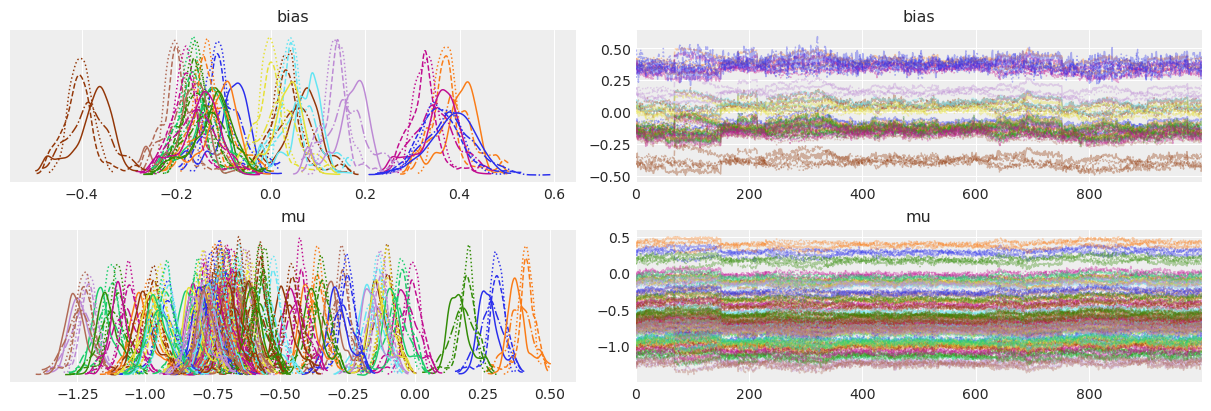

In [18]:
arviz.plot_trace(idata);

Because of the logistic link function, these coefficients can be tricky to interpret. When the bias is positive, this means that we need to add to the latent popularity to get the observation, which means that the (pollster, method) pair tends to be biased towards giving higher popularity scores.

This model clearly has issues: the trace plot is really ugly and the R-hat statistic is larger than 1.2 for some parameters, which indicates problems during sampling. This is not surprising: this model is _really_ simple. The important thing here is to diagnose the depth of the pathologies, and see how that points us to improvements.

Let's look at the summary table:

In [19]:
arviz.summary(idata, round_to=2)

/Users/alex_andorra/opt/anaconda3/envs/elections-models/lib/python3.9/site-packages/arviz/utils.py:124: UserWarning: Items starting with ~: ['popularity'] have not been found and will be ignored
  warnings.warn(


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
bias[0] -0.10  0.04   -0.19    -0.03       0.01     0.01     23.23     59.59   
bias[1]  0.38  0.04    0.30     0.45       0.01     0.01     22.39     62.47   
bias[2] -0.15  0.04   -0.23    -0.08       0.01     0.01     22.52     64.04   
bias[3]  0.34  0.04    0.26     0.42       0.01     0.01     23.70     63.04   
bias[4]  0.05  0.04   -0.03     0.13       0.01     0.01     24.94     65.23   
...       ...   ...     ...      ...        ...      ...       ...       ...   
mu[55]  -0.93  0.04   -1.02    -0.85       0.01     0.01     30.41     93.90   
mu[56]  -0.96  0.04   -1.04    -0.87       0.01     0.01     26.41     85.65   
mu[57]  -0.94  0.04   -1.02    -0.85       0.01     0.01     25.97     81.38   
mu[58]  -0.78  0.04   -0.86    -0.70       0.01     0.01     25.49     90.16   
mu[59]  -0.75  0.04   -0.83    -0.66       0.01     0.01     25.33     86.35   

         r_hat  
bias[0]   1.15  
bias[1]   1.15  
bias[2]   1.15  
bias[3]   1.14  
bias[4]   1.14  
...        ...  
mu[55]    1.11  
mu[56]    1.12  
mu[57]    1.12  
mu[58]    1.13  
mu[59]    1.13  

[75 rows x 9 columns]

Wow, that's bad! Do you see these much-too-high R_hat and much-too-low effective sample sizes (`ess_bulk` and `ess_tail`)?

Let's not spend too much time on this model, but before we move on, it's useful to see how bad our posterior predictions for `mu`, the estimated monthly latent popularity, look. Since the model is completely pooled, we only have 60 values, which correspond to a full term (i.e 5 years):

In [81]:
def plot_latent_mu(inference_data, overlay_observed=True):
    """Plot latent posterior popularity"""
    post_pop = logistic(
        inference_data.posterior["month_effect"].stack(sample=("chain", "draw"))
    )

    fig, ax = plt.subplots()
    for i in np.random.choice(post_pop.coords["sample"].size, size=1000):
        ax.plot(
            inference_data.posterior.coords["month"],
            post_pop.isel(sample=i),
            alpha=0.01,
            color="grey",
        )
    post_pop.mean("sample").plot(ax=ax, color="black", lw=2, label="predicted mean")

    if overlay_observed:
        obs_mean = (
            data.groupby(["president", "month_id"]).last()["p_approve_mean"].unstack().T
        )
        for president in obs_mean.columns:
            ax.plot(
                obs_mean.index,
                obs_mean[president],
                "o",
                alpha=0.3,
                label=f"obs. monthly {president}",
            )
    ax.set_xlabel("Months into term")
    ax.set_ylabel("Does approve")
    ax.legend()
    
    

fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True, sharey=True)

for ax, p in zip(axes.ravel(), idata.posterior.coords["president"]):
    post = idata.posterior.sel(president=p)
    post_pop = logistic(
        (
            post["baseline"]
            + post["president_effect"]
            + post["month_effect"]
            + post["month_president_effect"]
        ).stack(sample=("chain", "draw"))
    )
    # plot random posterior draws
    ax.plot(
        post.coords["month"],
        post_pop.isel(
            sample=np.random.choice(post_pop.coords["sample"].size, size=1000)
        ),
        alpha=0.01,
        color="grey",
    )
    # plot posterior mean
    post_pop.mean("sample").plot(
        ax=ax, color="black", lw=2, label="predicted mean"
    )
    # plot monthly raw polls
    ax.plot(
        obs_mean.index,
        obs_mean[p.data],
        "o",
        color="orange",
        alpha=0.8,
        label="observed monthly",
    )
    ax.set_xlabel("Months into term")
    ax.set_ylabel("Latent popularity")
    ax.legend()

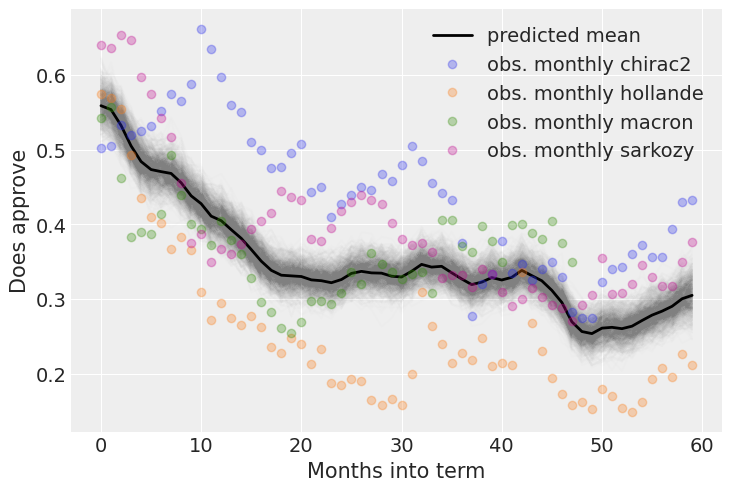

In [82]:
plot_latent_mu(idata)

Not too good, is it? The black line is the mean posterior latent monthly popularity estimated by the model. Each grey line is a draw from the posterior latent popularity, and each point is the observed monthly mean popularity in polls for each president.

No need to stare at this graph to notice that the model grossly underestimates the variance in the data. We also see that presidents differ quite a lot, although they have some common pattern (this is a clue for improving the model; can you guess how we could include that?). The good point though is that the model is highly influenced by the sample size: up until month 50, the posterior prediction stays close to wherever the most dots are clustered, because those values appear most frequently, so it's a safer bet. Between months 50 and 60, polls become more dispersed, so the model is doing a compromise, staying below the bulk of points but much higher than the lowest points. Here, what's troubling the model is that one of the presidents (François Hollande) was hugely unpopular at the end of his term compared to the others.

An easy and obvious way to improve this model is to allow the random walk's innovation to vary more. Maybe our model is too constrained by the fixed innovation and can't accomodate the variation in the data?

### Infer the standard deviation $\sigma$ of the random walk

Instead of fixing the random walk's innovation, let's estimate it from the data. The code is very similar:

In [62]:
with pm.Model(coords=COORDS) as pooled_popularity:

    house_effect = pm.Normal("house_effect", 0, 0.15, dims="pollster_by_method")
    sigma_mu = pm.HalfNormal("sigma_mu", 0.5)
    month_effect = pm.GaussianRandomWalk("month_effect", sigma=sigma_mu, dims="month")

    popularity = pm.math.invlogit(
        month_effect[month_id] + house_effect[pollster_by_method_id]
    )

    N_approve = pm.Binomial(
        "N_approve",
        p=popularity,
        n=data["samplesize"],
        observed=data["num_approve"],
        dims="observation",
    )

    idata = pm.sample(tune=2000, draws=2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma_mu, bias]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 52 seconds.


0, dim: observation, 1083 =? 1083


The acceptance probability does not match the target. It is 0.7073630440760919, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8911083130475927, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


Did this help convergence?

/Users/alex_andorra/opt/anaconda3/envs/elections-models/lib/python3.9/site-packages/arviz/utils.py:124: UserWarning: Items starting with ~: ['popularity'] have not been found and will be ignored
  warnings.warn(


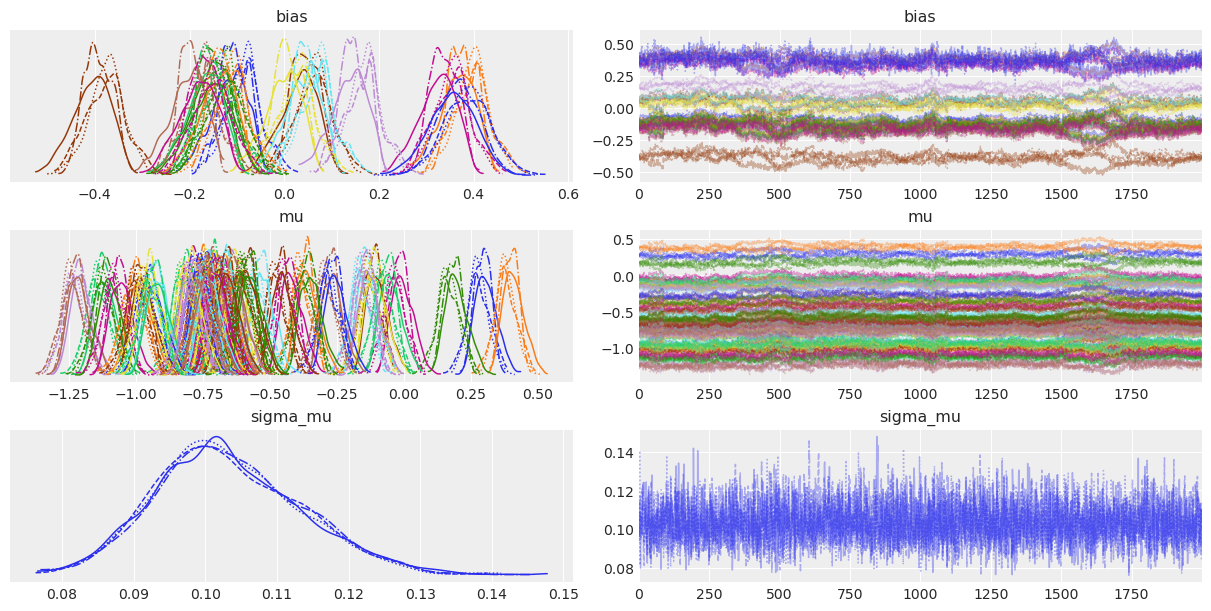

In [63]:
arviz.plot_trace(idata);

Aaaaah, my eyes, my eyes, please stop!

These trace plots are still very ugly. What about the R-hats and effective sample sizes?

In [64]:
arviz.summary(idata, round_to=2)

/Users/alex_andorra/opt/anaconda3/envs/elections-models/lib/python3.9/site-packages/arviz/utils.py:124: UserWarning: Items starting with ~: ['popularity'] have not been found and will be ignored
  warnings.warn(


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
bias[0]  -0.10  0.04   -0.18    -0.03       0.01      0.0     41.69     91.94   
bias[1]   0.38  0.04    0.30     0.45       0.01      0.0     41.02     91.65   
bias[2]  -0.15  0.04   -0.23    -0.08       0.01      0.0     43.28     93.63   
bias[3]   0.34  0.04    0.27     0.42       0.01      0.0     45.28     98.97   
bias[4]   0.05  0.04   -0.03     0.13       0.01      0.0     42.17     96.05   
...        ...   ...     ...      ...        ...      ...       ...       ...   
mu[56]   -0.96  0.04   -1.04    -0.88       0.01      0.0     49.35    132.37   
mu[57]   -0.93  0.04   -1.02    -0.85       0.01      0.0     51.57    115.37   
mu[58]   -0.79  0.04   -0.87    -0.71       0.01      0.0     45.97    114.20   
mu[59]   -0.75  0.04   -0.83    -0.67       0.01      0.0     53.05    132.34   
sigma_mu  0.10  0.01    0.08     0.12       0.00      0.0   4841.27   4900.70   

          r_hat  
bias[0]    1.12  
bias[1]    1.12  
bias[2]    1.12  
bias[3]    1.12  
bias[4]    1.12  
...         ...  
mu[56]     1.10  
mu[57]     1.10  
mu[58]     1.10  
mu[59]     1.10  
sigma_mu   1.00  

[76 rows x 9 columns]

Still very, very bad... The only good news is that we seem to efficiently estimate `sigma_mu`, the innovation of the random walk -- the R-hat is perfect and the ESS is high.

Do the posterior predictions look better?

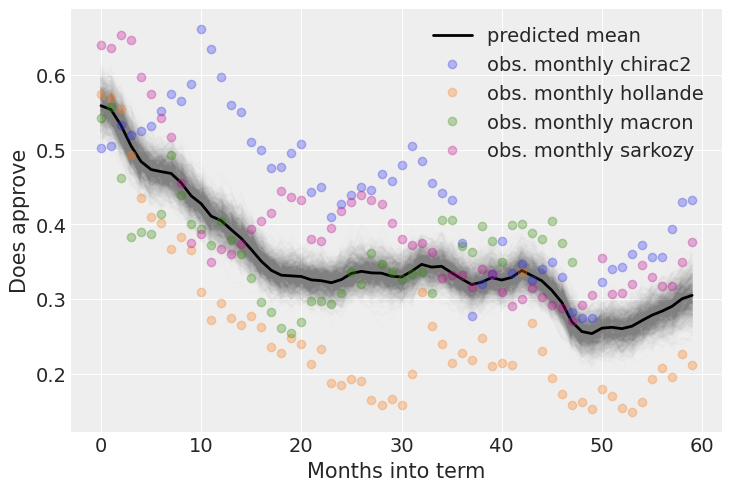

In [83]:
plot_latent_mu(idata)

The posterior variance of the values of $\mu$ still is grossly underestimated; between month 40 and 50 presidents have had popularity rates between 0.2 and 0.4, while here the popularity is estimated to be around 0.21 plus or minus 0.02 at best. We need to fhix this.

### A model that accounts for the overdispersion of polls

As we saw with the previous model, the variance of $\mu$'s posterior values is grossly underestimated. This comes from at least two things:

1. Presidents have similarities, but also a lot of differences in how their popularity rates evolves with time. We should take that into account and estimate one trendline per president. We'll do that later.

2. Even beyond president effects, it seems that there is much more variation in the data that a Binomial distribution expects (as is often the case with count data). This is called overdispersion of data in statistical linguo, and is due to the fact that the Binomial's variance depends on its mean. A convenient way to get around this limitation is to use a Beta-Binomial likelihood, to add one degree of freedom and allow the variance to be estimated independently from the mean value. For more details about this distribution and its parametrization, see [this blog post](https://alexandorra.github.io/pollsposition_blog/popularity/macron/gaussian%20processes/polls/2021/01/18/gp-popularity.html#Build-me-a-model). In short, this allows each poll to have its own Binomial probability, which even makes sense scientifically: it's conceivable that each poll is different in several ways from the others (even when done by the same pollster), because there are measurement errors and other factors we did not include, even beyond pollsters' and method's biases.

In [66]:
with pm.Model(coords=COORDS) as pooled_popularity:

    house_effect = pm.Normal("house_effect", 0, 0.15, dims="pollster_by_method")
    sigma_mu = pm.HalfNormal("sigma_mu", 0.5)
    month_effect = pm.GaussianRandomWalk("month_effect", sigma=sigma_mu, dims="month")

    popularity = pm.math.invlogit(
        month_effect[month_id] + house_effect[pollster_by_method_id]
    )

    # overdispersion parameter
    theta = pm.Exponential("theta_offset", 1.0) + 10.0

    N_approve = pm.BetaBinomial(
        "N_approve",
        alpha=popularity * theta,
        beta=(1.0 - popularity) * theta,
        n=data["samplesize"],
        observed=data["num_approve"],
        dims="observation",
    )

    idata = pm.sample(tune=2000, draws=2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_offset, mu, sigma_mu, bias]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 52 seconds.


0, dim: observation, 1083 =? 1083


The number of effective samples is smaller than 10% for some parameters.


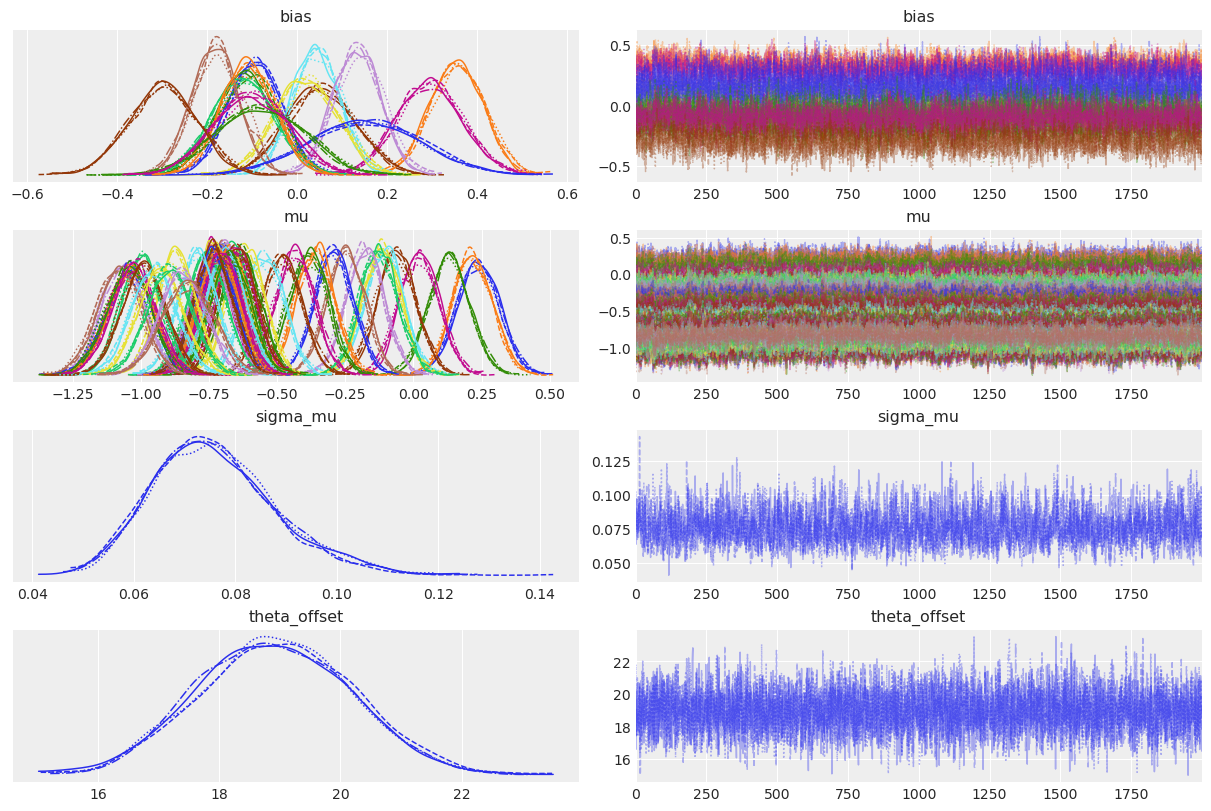

In [67]:
arviz.plot_trace(idata);

In [68]:
arviz.summary(idata, round_to=2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
bias[0]       -0.09  0.06   -0.21     0.02       0.00     0.00    744.05   
bias[1]        0.36  0.06    0.25     0.47       0.00     0.00    779.82   
bias[2]       -0.11  0.07   -0.24     0.01       0.00     0.00   1137.77   
bias[3]        0.30  0.07    0.16     0.44       0.00     0.00   1511.90   
bias[4]        0.05  0.08   -0.09     0.20       0.00     0.00   1825.90   
...             ...   ...     ...      ...        ...      ...       ...   
mu[57]        -0.90  0.08   -1.05    -0.74       0.00     0.00   1114.84   
mu[58]        -0.85  0.09   -1.01    -0.69       0.00     0.00   1153.00   
mu[59]        -0.83  0.10   -1.00    -0.64       0.00     0.00   1354.95   
sigma_mu       0.08  0.01    0.05     0.10       0.00     0.00   2040.68   
theta_offset  18.92  1.26   16.57    21.25       0.02     0.01   5997.38   

              ess_tail  r_hat  
bias[0]        2033.25   1.00  
bias[1]        2135.70   1.01  
bias[2]        2653.51   1.00  
bias[3]        2930.99   1.00  
bias[4]        3191.62   1.00  
...                ...    ...  
mu[57]         2949.10   1.00  
mu[58]         2201.66   1.00  
mu[59]         2536.87   1.00  
sigma_mu       3333.97   1.00  
theta_offset   5903.31   1.00  

[77 rows x 9 columns]

All of this is looking much better: only one sampling warning, really good-looking trace plot and much higher effective sample sizes (although it's still a bit low for some parameters).

What about the posterior predictions?

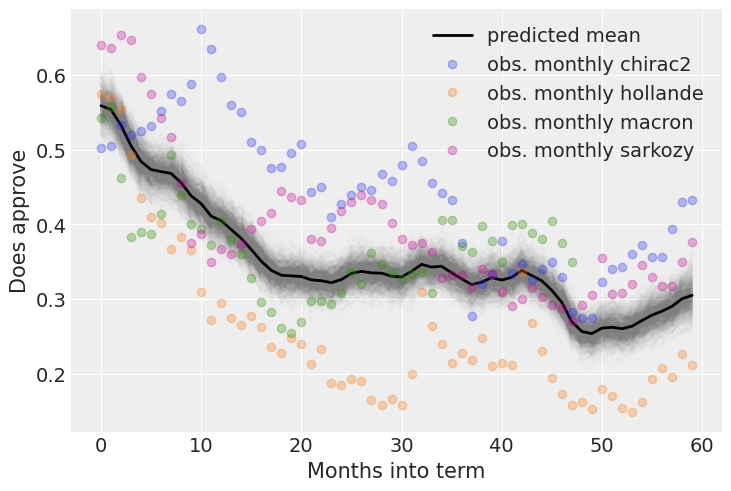

In [84]:
plot_latent_mu(idata)

This is better! We can see why the model is more comfortable: the Beta-Binomial likelihood give it more flexibility, as exemplified in the more wiggly posterior predictions, which also increases the uncertainty of the predictions.

Still, this is not very satisfactory. The main limit of this model is that it doesn't distinguish between presidents -- it pools all of them -- although they all have differences despite being similar in some ways. As a result, it is unlikely we would be able to do much better than this for the pooled model; maybe by having one dispersion term per term/month? 

I don't know about you, but each time I hear "similar but different", I immediately think of a hiearchical (i.e partially pooled) model (yeah, I'm weird sometimes). Well, that's exactly what we're going to investigate next!

### Hierarchical model

The main change is that now our `month_effect` will become a `month_president_effect`, and we'll have a common monthly mean for all presidents (which will be our new `month_effect`. A nice feature is that `sigma_mu` can now be interpreted as the shrinkage parameter of the random walk: the closest to zero it will be inferred to be, the more similar the presidents will be considered in their monthly popularity evolution. That's why we'll rename this parameter `shrinkage_pop`. Finally, the house effects stay unpooled, as they were before.

Let's code that up and sample!

In [86]:
president_id, presidents = data["president"].factorize(sort=False)
COORDS["president"] = presidents

In [87]:
with pm.Model(coords=COORDS) as hierarchical_popularity:

    house_effect = pm.Normal("house_effect", 0, 0.15, dims="pollster_by_method")
    month_effect = pm.Normal("month_effect", 0, 0.15, shape=len(COORDS["month"]) + 1)
    shrinkage_pop = pm.HalfNormal("shrinkage_pop", 0.2)
    month_president_effect = pm.GaussianRandomWalk(
        "month_president_effect",
        mu=month_effect,
        sigma=shrinkage_pop,
        dims=("president", "month"),
    )

    popularity = pm.math.invlogit(
        month_president_effect[president_id, month_id]
        + house_effect[pollster_by_method_id]
    )

    N_approve = pm.Binomial(
        "N_approve",
        p=popularity,
        n=data["samplesize"],
        observed=data["num_approve"],
        dims="observation",
    )

    idata = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [month_president_effect, shrinkage_pop, month_effect, house_effect]


RuntimeError: Chain 1 failed.

Uh-oh, our model doesn't sample... Apparently we've got zero derivates for some variables, whatever that means! Usually, this is due to missing values somewhere (which leads to -infinity log-probabilities), or just to some misspecification in the model (yep, life is complicated, we've got to accept it). A first step then is to check the model's test point and see whether we've got any -inf in there:

In [88]:
hierarchical_popularity.check_test_point()

house_effect                 14.67
month_effect                 59.67
shrinkage_pop_log__          -0.77
month_president_effect     9895.94
N_approve                -83867.83
Name: Log-probability of test_point, dtype: float64

Nope, everything looks good. So, the the problem doesn't come from missing values in the data but certainly from the model specification itself. We've checked, and there is no typo in the code above. A safe bet here is that the current parametrization (very poorly called "centered" parametrization) is somehow presenting the MCMC sampler with a vexing geometry. A common trick is to switch to a "non-centered parametrization", where `month_effect` and `shrinkage_pop` are estimated independently from `month_president_effect`, as you'll see in the code below.

This trick is a bit weird if that's the first time you're encountering it, so you can take a look at [this blog post](https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/) for further explanation.

In [89]:
with pm.Model(coords=COORDS) as hierarchical_popularity:

    house_effect = pm.Normal("house_effect", 0, 0.15, dims="pollster_by_method")

    month_effect = pm.Normal("month_effect", 0, 0.15, dims="month")
    sd = pm.HalfNormal("shrinkage_pop", 0.2)
    raw_rw = pm.GaussianRandomWalk("raw_rw", sigma=1.0, dims=("president", "month"))
    month_president_effect = pm.Deterministic(
        "month_president_effect",
        month_effect + raw_rw * sd,
        dims=("president", "month"),
    )

    popularity = pm.math.invlogit(
        month_president_effect[president_id, month_id]
        + house_effect[pollster_by_method_id]
    )

    N_approve = pm.Binomial(
        "N_approve",
        p=popularity,
        n=data["samplesize"],
        observed=data["num_approve"],
        dims="observation",
    )

    idata = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [raw_rw, shrinkage_pop, month_effect, house_effect]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 133 seconds.


0, dim: observation, 1083 =? 1083


The number of effective samples is smaller than 25% for some parameters.


Yep, that was it! Feels like magic, doesn't it? Each time I just switch from a centered to a non-centered parametrization and it just starts sampling, I am amazed!

We only got a small warning about effective sample size, so we expect the trace plot to look good. But do our estimates make sense?

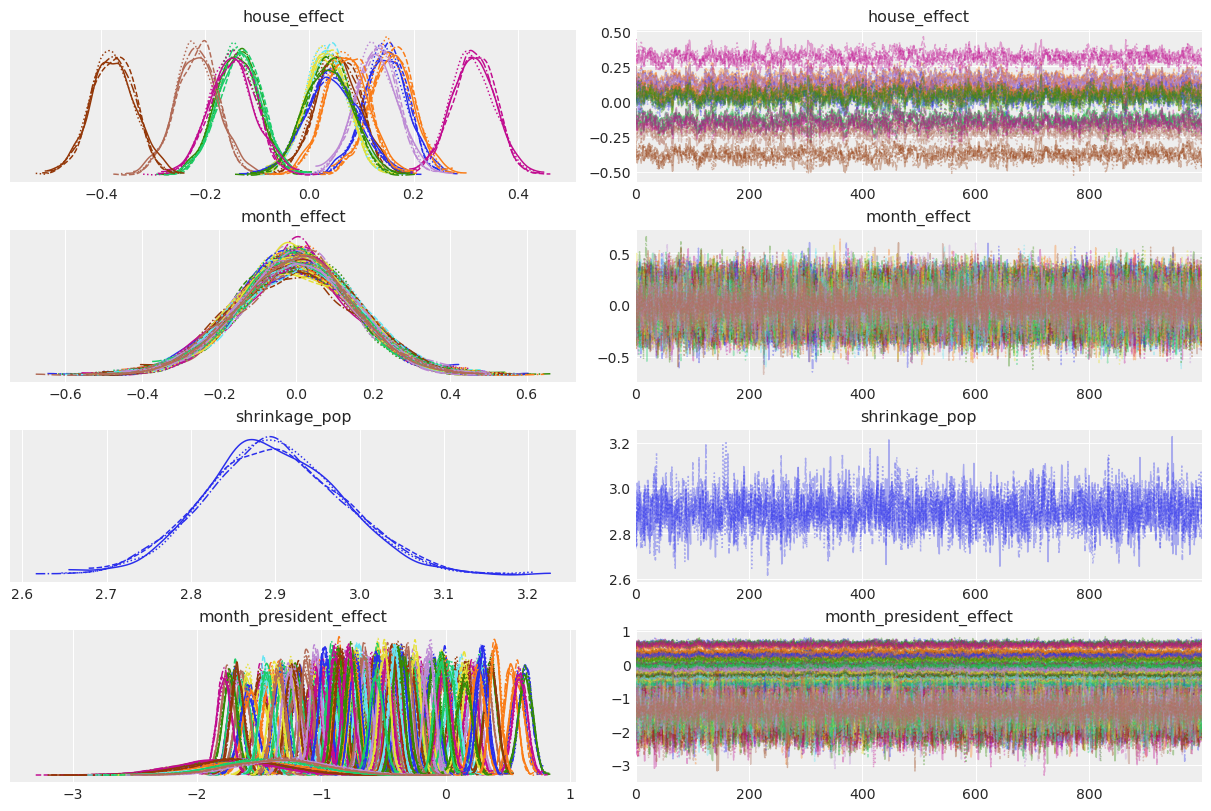

In [90]:
arviz.plot_trace(
    idata,
);

That looks a bit weird right? `shrinkage_pop`, the random walk's standard deviation, seems really high! That's basically telling us that the president's popularity can change a lot from one month to another, which we now from domain knowledge is not true. The `month_effect` are all similar and centered on 0, which means all months are very similar -- there can't really be a bad month or a good month. 

This is worrying for at least two reasons: 1) we _know_ from prior knowledge that there _are_ good and bad months for presidents; 2) this extreme similarity in `month_effect` directly contradicts the high `shrinkage_pop`: how can the standard deviation be so high if months are all the same?

So something is missing here. Actually, we should really have an intercept, which represents the baseline presidential approval, no matter the month and president. The tricky thing here is that `pm.GaussianRandomWalk` uses [a distribution to initiate the random walk](https://docs.pymc.io/api/distributions/timeseries.html#pymc3.distributions.timeseries.GaussianRandomWalk). So, if we don't constrain it to zero, we will get an additive non-identifiability -- for each president and month, we'll have two intercepts, `baseline` and the initial value of the random walk. `pm.GaussianRandomWalk` only accepts distribution objects for the `init` kwarg though, so we have to implement the random walk by hand, i.e:

$$\mu_n = \mu_{n - 1} + Z_n, \, with \, Z_n \sim Normal(0, 1) \, and \, \mu_0 = 0$$

In other words, a Gaussian random walk is just a cumulative sum, where we add a sample from a standard Normal at each step ($Z_n$ here, which is called the innovation of the random walk).

Finally, it's probably useful to add a `president_effect`: it's very probable that some presidents are just more popular than others, even when taking into account the cyclical temporal variations.

In [91]:
COORDS["month_minus_origin"] = COORDS["month"][1:]

In [93]:
with pm.Model(coords=COORDS) as hierarchical_popularity:

    baseline = pm.Normal("baseline")
    president_effect = pm.Normal("president_effect", sigma=0.15, dims="president")
    house_effect = pm.Normal("house_effect", 0.15, dims="pollster_by_method")

    month_effect = pm.Normal("month_effect", 0.15, dims="month")
    # need the cumsum parametrization to properly control the init of the GRW
    rw_init = aet.zeros(shape=(len(COORDS["president"]), 1))
    rw_innovations = pm.Normal(
        "rw_innovations",
        dims=("president", "month_minus_origin"),
    )
    raw_rw = aet.cumsum(aet.concatenate([rw_init, rw_innovations], axis=-1), axis=-1)
    sd = pm.HalfNormal("shrinkage_pop", 0.2)
    month_president_effect = pm.Deterministic(
        "month_president_effect", raw_rw * sd, dims=("president", "month")
    )

    popularity = pm.math.invlogit(
        baseline
        + president_effect[president_id]
        + month_effect[month_id]
        + month_president_effect[president_id, month_id]
        + house_effect[pollster_by_method_id]
    )

    N_approve = pm.Binomial(
        "N_approve",
        p=popularity,
        n=data["samplesize"],
        observed=data["num_approve"],
        dims="observation",
    )

    idata = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [shrinkage_pop, rw_innovations, month_effect, house_effect, president_effect, baseline]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 740 seconds.


0, dim: observation, 1083 =? 1083


No warnings whatsoever! Who would have thought that adding a simple intercept would help that much! Let's look at our expectedly beautiful trace plot 🤩

/Users/alex_andorra/opt/anaconda3/envs/elections-models/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/Users/alex_andorra/opt/anaconda3/envs/elections-models/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: invalid value encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/Users/alex_andorra/opt/anaconda3/envs/elections-models/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/Users/alex_andorra/opt/anaconda3/envs/elections-models/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: invalid value encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/Users/alex_andorra/opt/anaconda3/envs/elections-models/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in tr

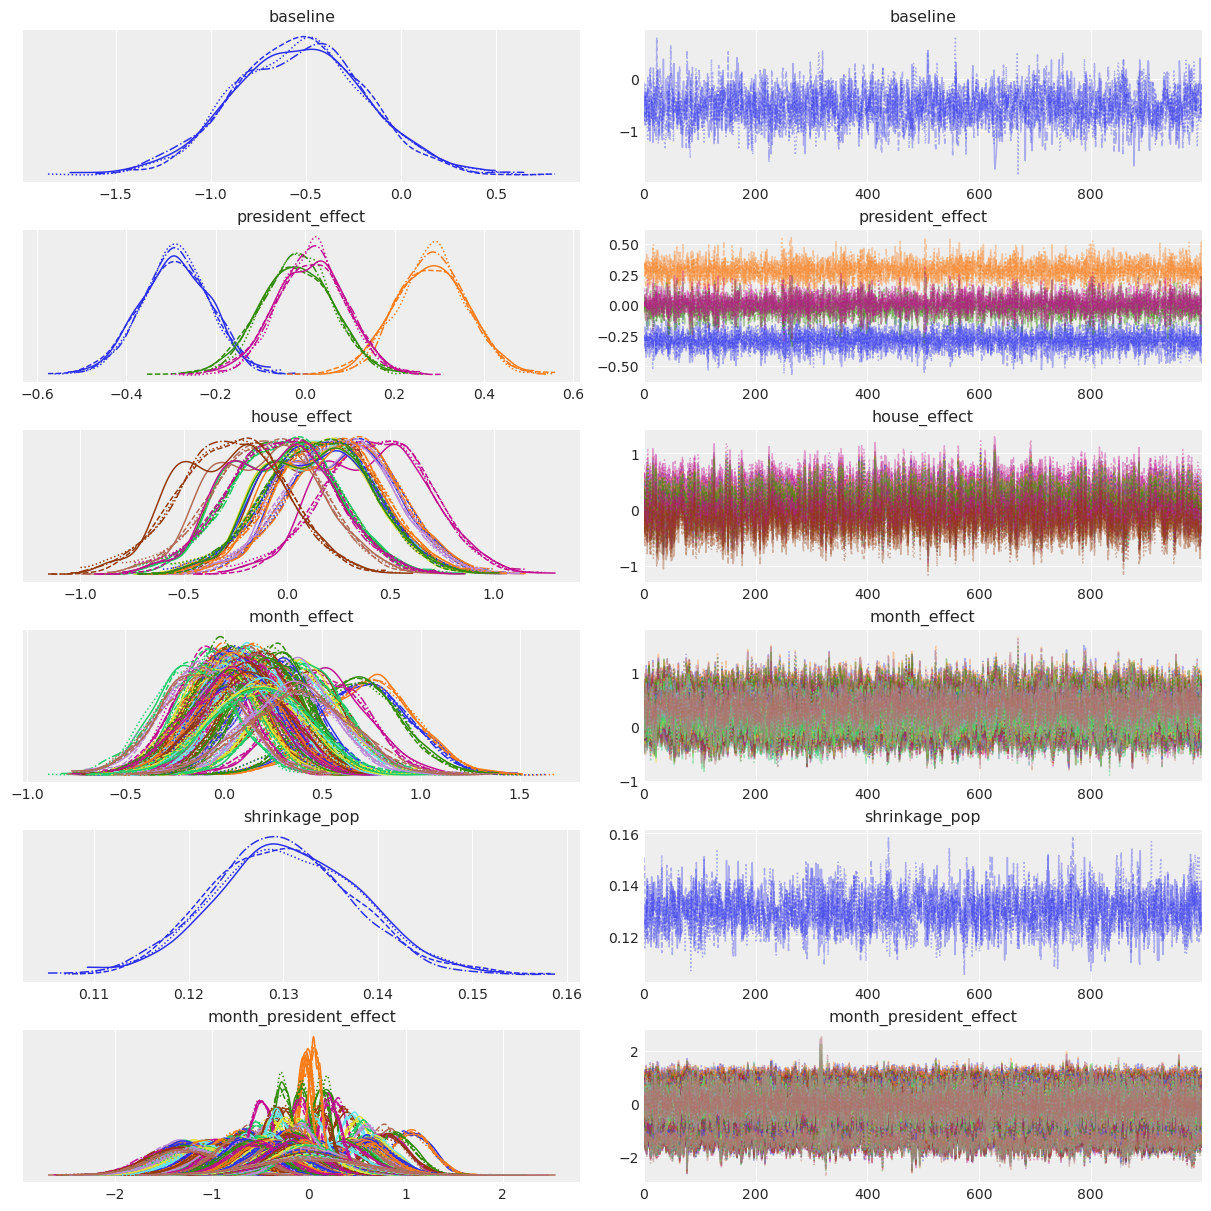

In [94]:
arviz.plot_trace(
    idata,
    var_names="~rw",
    filter_vars="regex",
);

That looks much better, doesn't it? Now we do see a difference in the different months, and the shrinkage standard deviation looks much more reasonable too, meaning that once we've accounted for the variation in popularity associated with the other effects, the different presidents' popularity isn't that different on a monthly basis -- i.e there _are_ cycles in popularity, no matter who the president is.

## Modelers just wanna have fuuuun!

We could stop there, but, for fun, let's improve this model even further by:

1. Using a Beta-Binomial likelihood. We already saw in the completely pooled model that it improves fit and convergence a lot. Plus, it makes scientific sense: for a lot of reasons, each poll probably has a different true Binomial probability than all the other ones -- even when it comes from the same pollster; just think about measurement errors or the way the sample is different each time. Here, we parametrize the Beta-Binomial by its mean and precision, instead of the classical $\alpha$ and $\beta$ parameters. For more details about this distribution and parametrization, see [this blog post](https://alexandorra.github.io/pollsposition_blog/popularity/macron/gaussian%20processes/polls/2021/01/18/gp-popularity.html#Build-me-a-model).

2. Making sure that our different effects sum to zero. Think about the month effect. It only makes sense in a relative sense: some months are better than average, some others are worse, but you can't have _only_ good months -- they'd be good compared to what? So we want to make sure that the average month effect is 0, while allowing each month to be better or worse than average if needed. To do that, we use a Normal distribution whose last axis is constrained to sum to zero. In PyMC, we can use the `ZeroSumNormal` distribution, that [Adrian Seyboldt](https://github.com/aseyboldt) contributed and kindly shared with us.

Ok, enough talking, let's code!

In [95]:
from typing import *


def ZeroSumNormal(
    name: str,
    sigma: float = 1.0,
    *,
    dims: Union[str, Tuple[str]],
    model: Optional[pm.Model] = None,
):
    """
    Multivariate normal, such that sum(x, axis=-1) = 0.

    Parameters

    name: str
        String name representation of the PyMC variable.
    sigma: float, defaults to 1
        Scale for the Normal distribution. If none is provided, a standard Normal is used.
    dims: Union[str, Tuple[str]]
        Dimension names for the shape of the distribution.
        See https://docs.pymc.io/pymc-examples/examples/pymc3_howto/data_container.html for an example.
    model: Optional[pm.Model], defaults to None
        PyMC model instance. If ``None``, a model instance is created.

    Notes
    ----------
    Contributed by Adrian Seyboldt (@aseyboldt).
    """
    if isinstance(dims, str):
        dims = (dims,)

    model = pm.modelcontext(model)
    *dims_pre, dim = dims
    dim_trunc = f"{dim}_truncated_"
    (shape,) = model.shape_from_dims((dim,))
    assert shape >= 1

    model.add_coords({f"{dim}_truncated_": pd.RangeIndex(shape - 1)})
    raw = pm.Normal(
        f"{name}_truncated_", dims=tuple(dims_pre) + (dim_trunc,), sigma=sigma
    )
    Q = make_sum_zero_hh(shape)
    draws = aet.dot(raw, Q[:, 1:].T)

    return pm.Deterministic(name, draws, dims=dims)


def make_sum_zero_hh(N: int) -> np.ndarray:
    """
    Build a householder transformation matrix that maps e_1 to a vector of all 1s.
    """
    e_1 = np.zeros(N)
    e_1[0] = 1
    a = np.ones(N)
    a /= np.sqrt(a @ a)
    v = a + e_1
    v /= np.sqrt(v @ v)
    return np.eye(N) - 2 * np.outer(v, v)

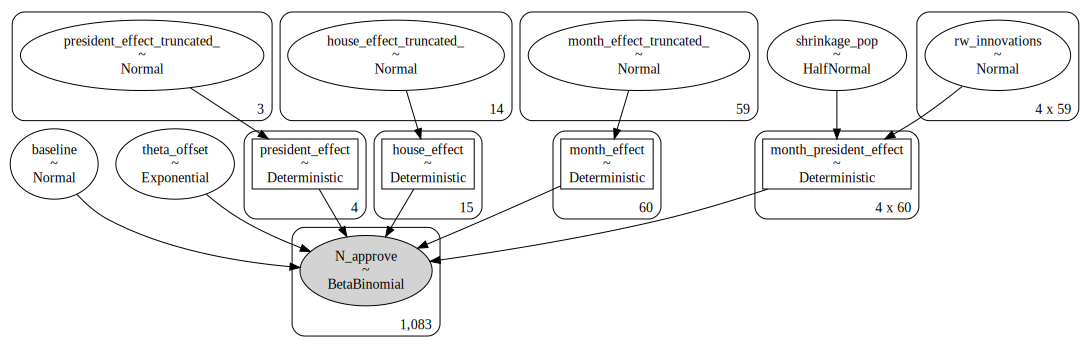

In [98]:
with pm.Model(coords=COORDS) as hierarchical_popularity:

    baseline = pm.Normal("baseline")
    president_effect = ZeroSumNormal("president_effect", sigma=0.15, dims="president")
    house_effect = ZeroSumNormal("house_effect", sigma=0.15, dims="pollster_by_method")
    month_effect = ZeroSumNormal("month_effect", sigma=0.15, dims="month")

    # need the cumsum parametrization to properly control the init of the GRW
    rw_init = aet.zeros(shape=(len(COORDS["president"]), 1))
    rw_innovations = pm.Normal(
        "rw_innovations",
        dims=("president", "month_minus_origin"),
    )
    raw_rw = aet.cumsum(aet.concatenate([rw_init, rw_innovations], axis=-1), axis=-1)
    sd = pm.HalfNormal("shrinkage_pop", 0.2)
    month_president_effect = pm.Deterministic(
        "month_president_effect", raw_rw * sd, dims=("president", "month")
    )

    popularity = pm.math.invlogit(
        baseline
        + president_effect[president_id]
        + month_effect[month_id]
        + month_president_effect[president_id, month_id]
        + house_effect[pollster_by_method_id]
    )

    # overdispersion parameter
    theta = pm.Exponential("theta_offset", 1.0) + 10.0

    N_approve = pm.BetaBinomial(
        "N_approve",
        alpha=popularity * theta,
        beta=(1.0 - popularity) * theta,
        n=data["samplesize"],
        observed=data["num_approve"],
        dims="observation",
    )
pm.model_to_graphviz(hierarchical_popularity)

In [99]:
with hierarchical_popularity:
    idata = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_offset, shrinkage_pop, rw_innovations, month_effect_truncated_, house_effect_truncated_, president_effect_truncated_, baseline]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 198 seconds.


0, dim: observation, 1083 =? 1083


Sampling was lightning fast, with a 4x improvement over our previous model! And we don't have any warnings, aka the best of both worlds.

/Users/alex_andorra/opt/anaconda3/envs/elections-models/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/Users/alex_andorra/opt/anaconda3/envs/elections-models/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: invalid value encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/Users/alex_andorra/opt/anaconda3/envs/elections-models/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/Users/alex_andorra/opt/anaconda3/envs/elections-models/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: invalid value encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/Users/alex_andorra/opt/anaconda3/envs/elections-models/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in tr

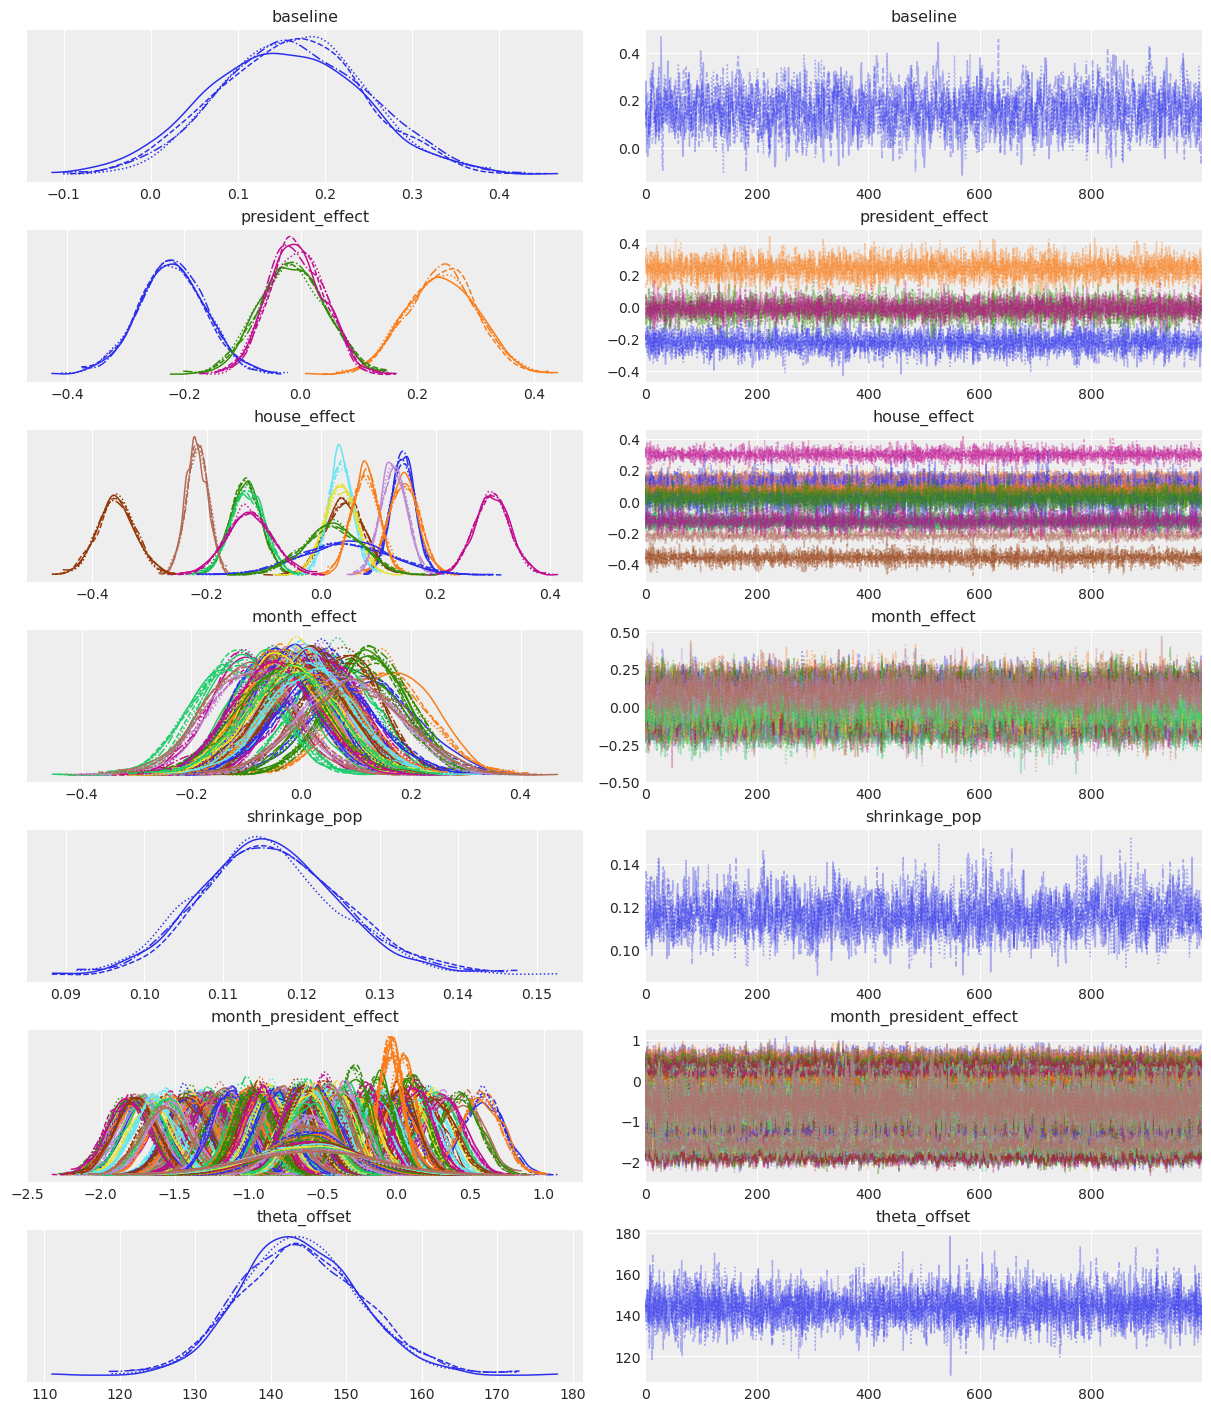

In [100]:
arviz.plot_trace(
    idata,
    var_names=["~truncated", "~rw_innovations"],
    filter_vars="regex",
    compact=True,
);

In [101]:
arviz.summary(
    idata,
    round_to=2,
    var_names=["~truncated", "~rw_innovations"],
    filter_vars="regex",
)

/Users/alex_andorra/opt/anaconda3/envs/elections-models/lib/python3.9/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/alex_andorra/opt/anaconda3/envs/elections-models/lib/python3.9/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/alex_andorra/opt/anaconda3/envs/elections-models/lib/python3.9/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/alex_andorra/opt/anaconda3/envs/elections-models/lib/python3.9/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_

mean    sd  hdi_3%  hdi_97%  mcse_mean  \
baseline                        0.16  0.08    0.01     0.32       0.00   
president_effect[0]            -0.22  0.06   -0.33    -0.11       0.00   
president_effect[1]             0.24  0.06    0.12     0.35       0.00   
president_effect[2]            -0.01  0.06   -0.12     0.09       0.00   
president_effect[3]            -0.01  0.05   -0.09     0.08       0.00   
...                              ...   ...     ...      ...        ...   
month_president_effect[3,56]   -0.59  0.39   -1.30     0.15       0.00   
month_president_effect[3,57]   -0.59  0.41   -1.42     0.11       0.01   
month_president_effect[3,58]   -0.59  0.42   -1.42     0.17       0.01   
month_president_effect[3,59]   -0.59  0.44   -1.40     0.26       0.01   
theta_offset                  143.88  7.95  129.01   158.63       0.11   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
baseline                         0.00   1747.77   2008.27    1.0  
president_effect[0]              0.00   5296.34   3363.12    1.0  
president_effect[1]              0.00   6344.90   3215.37    1.0  
president_effect[2]              0.00   5243.53   3094.95    1.0  
president_effect[3]              0.00   4792.66   3283.50    1.0  
...                               ...       ...       ...    ...  
month_president_effect[3,56]     0.00   6173.50   2740.68    1.0  
month_president_effect[3,57]     0.01   6312.81   2680.89    1.0  
month_president_effect[3,58]     0.01   6284.10   2496.36    1.0  
month_president_effect[3,59]     0.01   6119.86   2278.52    1.0  
theta_offset                     0.08   5753.23   3004.72    1.0  

[322 rows x 9 columns]

And now let's do something new! Let's visualize the posterior estimates of the house effects. We'll plot the mean value for each `(pollster, method)` pair. Remember, a _positive_ house effect means the given pair tend to _overestimate_ the latent popularity:

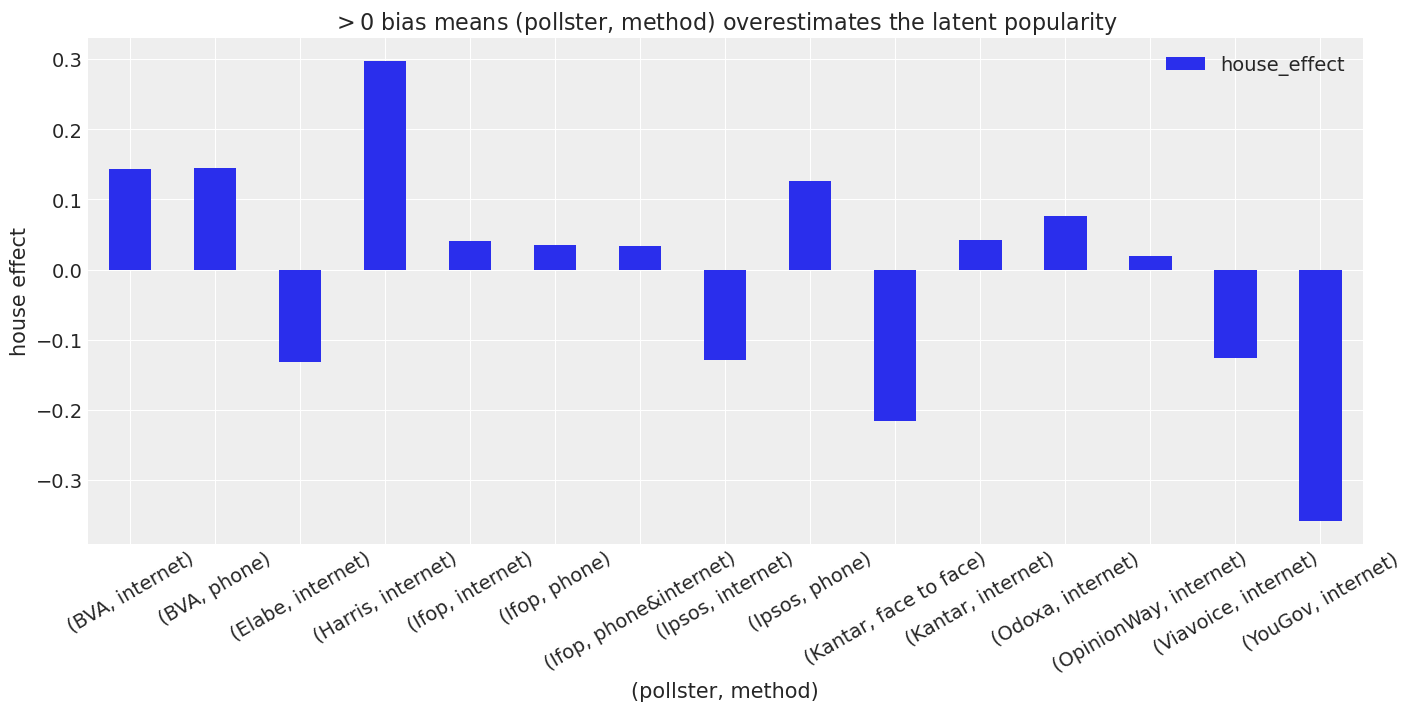

In [125]:
mean_house_effect = (
    idata.posterior["house_effect"].mean(("chain", "draw")).to_dataframe()
)
ax = mean_house_effect.plot.bar(figsize=(14, 7), rot=30)
ax.set_xlabel("(pollster, method)")
ax.set_ylabel("house effect")
ax.set_title("$>0$ bias means (pollster, method) overestimates the latent popularity");

All this is inline with what I usually observe when I collect the polls each month (yes, by hand, thanks for asking, that's so cute!):

- BVA tends to be a bit higher than average, no matter the method. Harris tends to be higher too, while Viavoice, Elabe and, especially, YouGov tend to be report much lower results than the average pollster.
- As suspected, Kantar is lower than average when using face-to-face, but is now within the average since it shifted to internet in January 2021. Interestingly, it goes the other way around for Ipsos: internet has a slightly negative bias for them, while phone has a slightly positive one.

Now let's look at our posterior predictions. This time, we can distinguish each president, which probably helped the model tremendously:

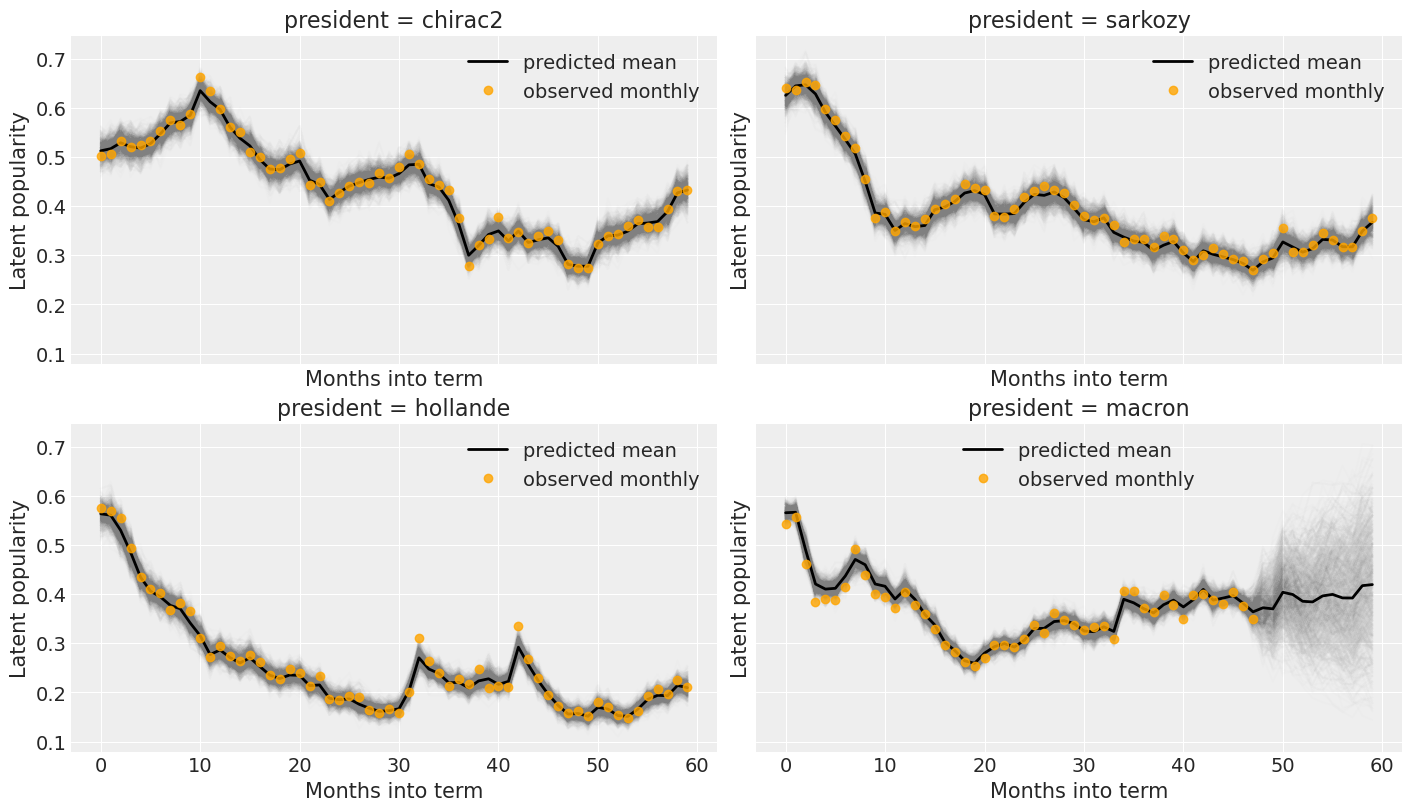

In [141]:
obs_mean = data.groupby(["president", "month_id"]).last()["p_approve_mean"].unstack().T

fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True, sharey=True)

for ax, p in zip(axes.ravel(), idata.posterior.coords["president"]):
    post = idata.posterior.sel(president=p)
    post_pop = logistic(
        (
            post["baseline"]
            + post["president_effect"]
            + post["month_effect"]
            + post["month_president_effect"]
        ).stack(sample=("chain", "draw"))
    )
    # plot random posterior draws
    ax.plot(
        post.coords["month"],
        post_pop.isel(
            sample=np.random.choice(post_pop.coords["sample"].size, size=1000)
        ),
        alpha=0.01,
        color="grey",
    )
    # plot posterior mean
    post_pop.mean("sample").plot(
        ax=ax, color="black", lw=2, label="predicted mean"
    )
    # plot monthly raw polls
    ax.plot(
        obs_mean.index,
        obs_mean[p.data],
        "o",
        color="orange",
        alpha=0.8,
        label="observed monthly",
    )
    ax.set_xlabel("Months into term")
    ax.set_ylabel("Latent popularity")
    ax.legend()

Quite the improvement uh? The model is much, much better at tracking each president's popoularity now -- this extension to a hierarchical structure proved very necessary!

Another way to check our model's performance is to generate plausible polls from it, and compare them to the _actual_ polls. This is a genuine posterior retrodictive check: we generate data from our model and check how plausible they are, compared to the observed data and our domain knowledge. Contrary to our previous plot, this kind of checks integrate all the model uncertainty down to the likelihood, so it's directly comparable to the observed data. 

In particular, we can see in the plot above that the model still has one weakness: it has troubles when the popularity rate varies widely from one month to the next. These wild bumps happen for various reasons, usually in answer to big political events. Although they vary in magnitude, we do see a few of them in each mandate, and each time the model wasn't aggressive in enough in keeping in line with them. That could be trouble for out-of-sample predictions and could be improved in a subsequent version of the model.

Compution posterior predictive samples is just one line of code in PyMC3. We'll also extend our current `InferenceData` object with these posterior predictive samples, to be able to use all the xarray goodies in our plot (for a quick start on ArviZ's `InferenceData`'s awesomness for multidimensional data, [click here](https://arviz-devs.github.io/arviz/getting_started/XarrayforArviZ.html)).

In [106]:
with hierarchical_popularity:
    idata.extend(
        arviz.from_pymc3(
            posterior_predictive=pm.sample_posterior_predictive(idata),
        )
    )

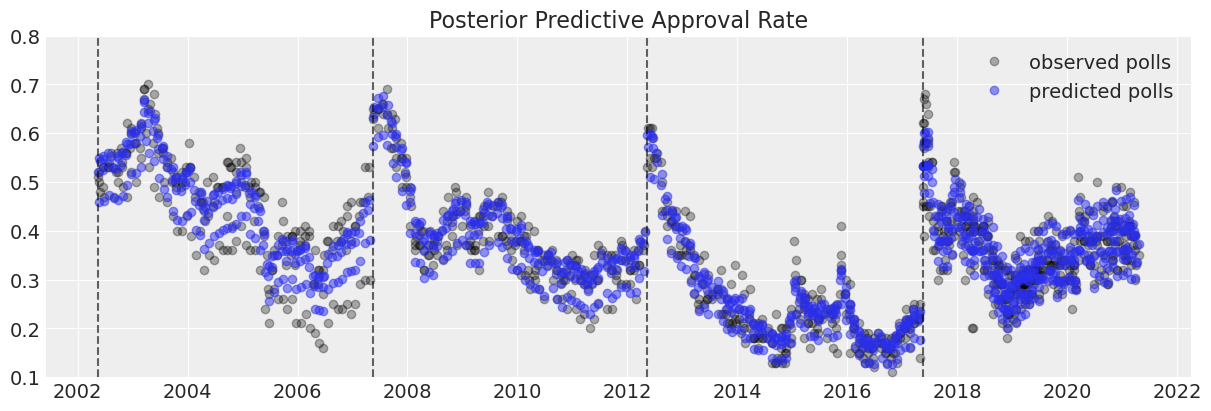

In [142]:
predicted_approval_rates = (
    idata.posterior_predictive.mean(("chain", "draw"))["N_approve"] / data["samplesize"]
)
dates = predicted_approval_rates.field_date

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(dates, data["p_approve"].values, "o", color="k", alpha=0.3, label="observed polls")
ax.plot(dates, predicted_approval_rates, "o", alpha=0.5, label="predicted polls")
ax.set_ylim(0.1, 0.8)
ax.set_title("Posterior Predictive Approval Rate")
ax.legend()
for date in newterm_dates:
    ax.axvline(date, color="k", alpha=0.6, linestyle="--")

These are really good predictions 😲 ! The model has very little trouble tracking the evolution and variation of each president's popularity, so we can be happy with ourselves. Interestingly though, we still see this tendency of the model to slightly underestimate the variation in raw polls, especially when big, sudden shifts in opinion happen, as we already mentioned. Although we don't want to _exactly_ replicate the observed data (some polls really are outliers and that's good that the model doesn't overfit), it would be interesting to see if the model can be further improved in this respect.

And that, ladies and gentlemen, was our workflow for a Bayesian hidden Markov model of 🇫🇷 presidents' popularity! We hope you enjoyed it, and feel free to comment below or reach out for any comments or suggestions. By the way, what do you think of this model? Are you surprised that French people tend to dislike their presidents?

![MicDropUrl](https://media.giphy.com/media/3o7qDEq2bMbcbPRQ2c/giphy.gif)

In [143]:
%load_ext watermark
%watermark -n -u -v -iv

Last updated: Sun May 16 2021

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.22.0

pymc3     : 3.11.2
numpy     : 1.20.2
arviz     : 0.11.2
matplotlib: 3.4.1
pandas    : 1.2.4
theano    : 1.1.2

